# Attention Model
## Author: Gary Corcoran
## Date: Jan. 4th, 2017

Attention Label Classiftion of Dashcam videos.

### Read Input Data
Input data is stored in a numpy matrix consisting of each RGB image resized to $(100 \times 100)$

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# display inline figures
%matplotlib inline

# data manipulation helpers
def shuffle(X, y):
    """
    Shuffle Input Matrices.
    
    @param X: input data matrix [num_instances,num_seqs,width,height,depth]
                @pre numpy matrix
    @param y: input labels matrix [num_instances]
                @pre numpy matrix
                
    @return shuffled data
    """
    idx = np.random.permutation(len(X))
    X = X[idx]
    y = y[idx]
    return X, y

def split_normalize_data(X, y):
    """
    Split Dataset and Normalize Data.
    
    @param X: input data matrix [num_instances,num_seqs,width,height,depth]
                @pre numpy matrix
    @param y: input labels matrix [num_instances]
                @pre numpy matrix
                
    @return training, validation and test datasets
    """
    X_train, X_val, X_test = np.split(X, [int(0.6*len(X)), int(0.8*len(X))])
    y_train, y_val, y_test = np.split(y, [int(0.6*len(y)), int(0.8*len(y))])
    print('X_train:', X_train.shape, 'y_train:', y_train.shape)
    print('X_val:', X_val.shape, 'y_val:', y_val.shape)
    print('X_test:', X_test.shape, 'y_test:', y_test.shape)
    # normalize input data (0 mean, unit variance)
    X_train, X_val, X_test = normalize(X_train, X_val, X_test)
    training_data = X_train, y_train
    validation_data = X_val, y_val
    test_data = X_test, y_test
    return training_data, validation_data, test_data

def normalize(X_train, X_val, X_test):
    """
    Normalize Input Data.
    
    After normalization the training input data should have a mean 0 and a
    standard deviation of 1.
    
    @param X_train: input training data
    @param X_val:   input validation data
    @param X_test:  input test data
    
    @return normalized input data
    """
    # normalize training data
    m = np.mean(np.mean(X_train, axis=0), axis=0)
    X_train = np.asarray(X_train - m, dtype=np.float32)
    std = np.std(X_train)
    X_train /= std
    # normalize validation data
    X_val = np.asarray((X_val - m) / std, dtype=np.float32)
    # normalize test data
    X_test = np.asarray((X_test - m) / std, dtype=np.float32)
    return X_train, X_val, X_test

# read input data
data_path = '../data/'
# X is dimensions [num_instances, num_seqs, width, height, depth]
X = np.load(data_path + 'X_videos_small.npy')
# y is dimensions [num_instances] (0=low attention, 1=medium attention,
# 2=high attention, 3=very high attention)
y = np.load(data_path + 'y_videos_small.npy')
# shuffle data
X, y = shuffle(X, y)
# split data
training_data, validation_data, test_data = split_normalize_data(X, y)
X_train, y_train = training_data
X_val, y_val = validation_data
X_test, y_test = test_data
# number of examples
n_train = len(X_train)
n_val = len(X_val)
n_test = len(X_test)

X_train: (60, 100, 100, 100, 3) y_train: (60,)
X_val: (20, 100, 100, 100, 3) y_val: (20,)
X_test: (20, 100, 100, 100, 3) y_test: (20,)


### Displayed Sampled Videos
Images from video frame are sampled 20 frames apart.

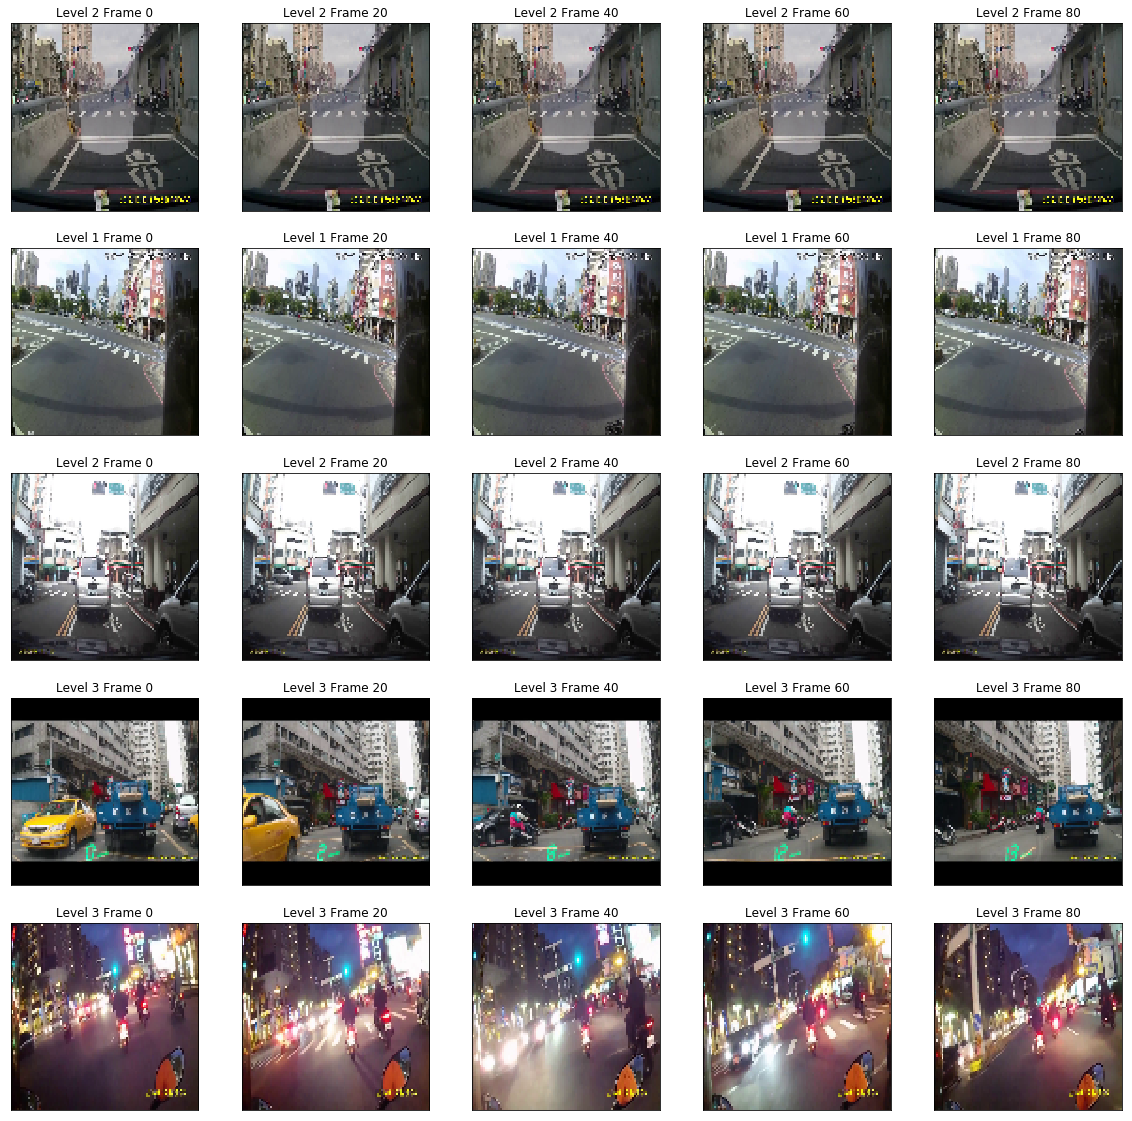

In [58]:
# display 5 sampled videos
plt.figure(figsize=(20,20))
for i, idx in enumerate(np.random.randint(len(X), size=5)):
    vid = X[idx]
    label = y[idx] + 1
    for j, frame in enumerate(range(0, 100, 20)):
        plt.subplot(5, 5, i*5+j+1)
        plt.imshow(cv2.cvtColor(vid[frame], cv2.COLOR_BGR2RGB))
        plt.title('Level ' + str(label) + ' Frame ' + str(frame))
        plt.xticks([]), plt.yticks([])
plt.show()